In [1]:
import os
import time
import math
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from tqdm import tqdm
import pickle

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def compute_and_save_attention_weights(model, tokenizer, passages, device, save_dir, max_length=512):
    """
    Computes and saves attention weights for each passage.

    Args:
        model (nn.Module): The language model.
        tokenizer (AutoTokenizer): The tokenizer for the model.
        passages (list of str): List of text passages.
        device (torch.device): The device to run the computation on.
        save_dir (str): Directory to save attention weights.
        max_length (int): Maximum sequence length for each chunk.
    """
    ensure_dir(save_dir)
    model.to(device)
    model.eval()

    with torch.no_grad():
        for idx, passage in enumerate(tqdm(passages, desc="Processing Passages")):
            inputs = tokenizer(passage, return_tensors="pt", truncation=True, max_length=max_length).to(device)
            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions  # Tuple of (num_layers) tensors

            # Detach and move to CPU
            attentions_cpu = [attn.squeeze(0).cpu() for attn in attentions]  # List of tensors per layer

            # Save attention weights using pickle
            save_path = os.path.join(save_dir, f"attention_{idx:04d}.pkl")
            with open(save_path, 'wb') as f:
                pickle.dump(attentions_cpu, f)

def load_passages(file_path, num_passages=1000):
    """
    Loads passages from a text file.

    Args:
        file_path (str): Path to the text file containing passages.
        num_passages (int): Number of passages to load.

    Returns:
        list of str: List of text passages.
    """
    passages = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                passages.append(line)
                if len(passages) >= num_passages:
                    break
    return passages

# Configuration
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with the correct model name if different
TEXT_FILE = "sample_data.txt"  # Path to your text file containing passages
SAVE_DIRECTORY = "attention_weights"  # Directory to save attention weights
NUM_PASSAGES = 1000  # Number of passages to process
MAX_LENGTH = 1024  # Maximum token length per passage

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_attentions=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load passages
passages = load_passages(TEXT_FILE, num_passages=NUM_PASSAGES)
print(f"Loaded {len(passages)} passages.")

# Compute and save attention weights
start_time = time.time()
compute_and_save_attention_weights(model, tokenizer, passages, device, SAVE_DIRECTORY, max_length=MAX_LENGTH)
end_time = time.time()
print(f"Attention weights saved to '{SAVE_DIRECTORY}'.")
print(f"Total time: {end_time - start_time:.2f} seconds")

# Example of loading and inspecting a saved attention file
def load_attention(file_path) -> Tuple[torch.Tensor]:
    """
    Loads attention weights from a pickle file.

    Args:
        file_path (str): Path to the pickle file.

    Returns:
        Tuple[torch.Tensor]: Tuple of attention tensors per layer.
    """
    with open(file_path, 'rb') as f:
        attentions = pickle.load(f)
    return tuple(attentions)

/home/oppenheimer/anaconda3/envs/wip/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/oppenheimer/anaconda3/envs/wip/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

Using device: cuda
Loaded 1000 passages.


Processing Passages: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.59it/s]

Attention weights saved to 'attention_weights'.
Total time: 26.79 seconds


In [2]:
attention_0001 = load_attention(os.path.join(SAVE_DIRECTORY, "attention_0001.pkl"))
print(attention_0001[0].shape)  # Shape: (num_heads, seq_length, seq_length)

torch.Size([32, 11, 11])


In [8]:
attention_0001[0]

tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.2921e-01, 2.7079e-01, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4480e-01, 8.2553e-01, 2.9672e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [7.2365e-02, 3.8937e-02, 3.4060e-02,  ..., 1.0264e-02,
          0.0000e+00, 0.0000e+00],
         [1.1429e-01, 2.8758e-02, 2.3291e-02,  ..., 9.4799e-02,
          4.6203e-02, 0.0000e+00],
         [9.4735e-02, 2.8413e-02, 2.6560e-02,  ..., 1.2516e-01,
          7.9799e-02, 1.1594e-01]],

        [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [8.8143e-01, 1.1857e-01, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.1340e-02, 9.1742e-01, 4.1237e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.3997e-01, 1.8664e-02, 4.6954e-04,  ..., 7.8469e-02,
          0.000

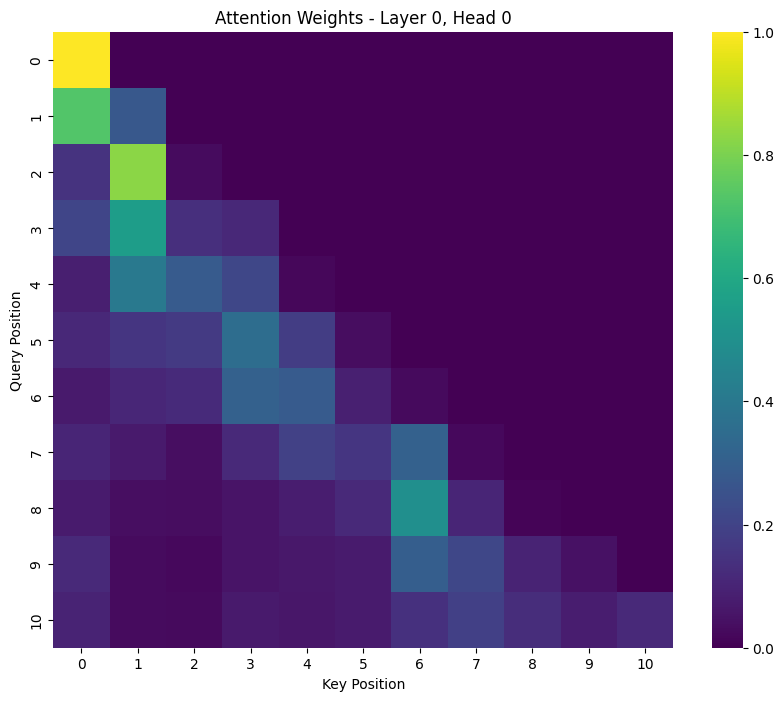

In [9]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def load_attention(file_path) -> Tuple[torch.Tensor]:
    """
    Loads attention weights from a pickle file.

    Args:
        file_path (str): Path to the pickle file.

    Returns:
        Tuple[torch.Tensor]: Tuple of attention tensors per layer.
    """
    with open(file_path, 'rb') as f:
        attentions = pickle.load(f)
    return tuple(attentions)

# Path to the saved attention file
attention_file = "attention_weights/attention_0001.pkl"

# Load attention weights
attention = load_attention(attention_file)

# Select the first layer and the first head
layer_idx = 0
head_idx = 0
attn_matrix = attention[layer_idx][head_idx].numpy()  # Shape: (seq_length, seq_length)

# Plot the attention matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attn_matrix, cmap='viridis')
plt.title(f'Attention Weights - Layer {layer_idx}, Head {head_idx}')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()


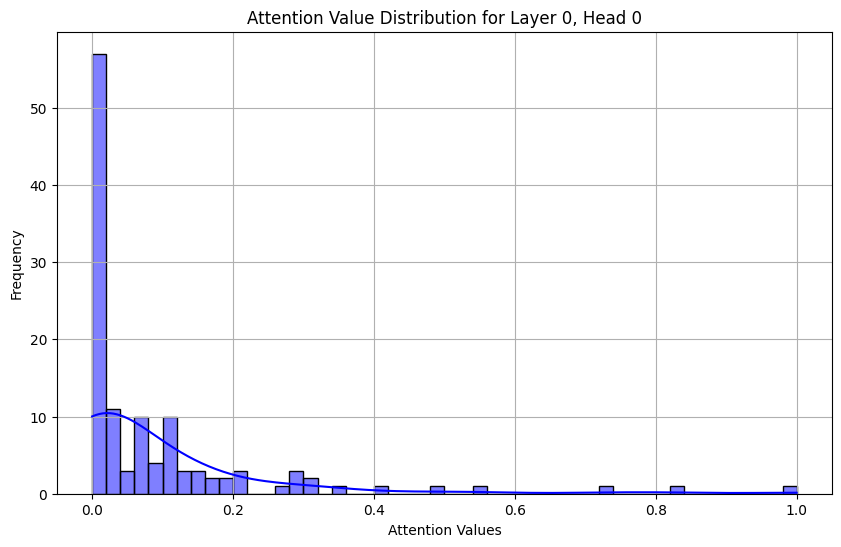

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_distribution(attn_matrix, title="Attention Value Distribution"):
    """
    Plots the distribution of values in the attention matrix.

    Args:
        attn_matrix (np.ndarray): The attention matrix (seq_length x seq_length).
        title (str): Title of the plot.
    """
    # Flatten the matrix to get all values
    attn_values = attn_matrix.flatten()

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(attn_values, kde=True, bins=50, color='blue')
    plt.title(title)
    plt.xlabel('Attention Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `attn_matrix` is the attention matrix from attention_0001[0]
attn_matrix_np = attn_matrix  # Convert to NumPy array if needed
plot_value_distribution(attn_matrix_np, title="Attention Value Distribution for Layer 0, Head 0")


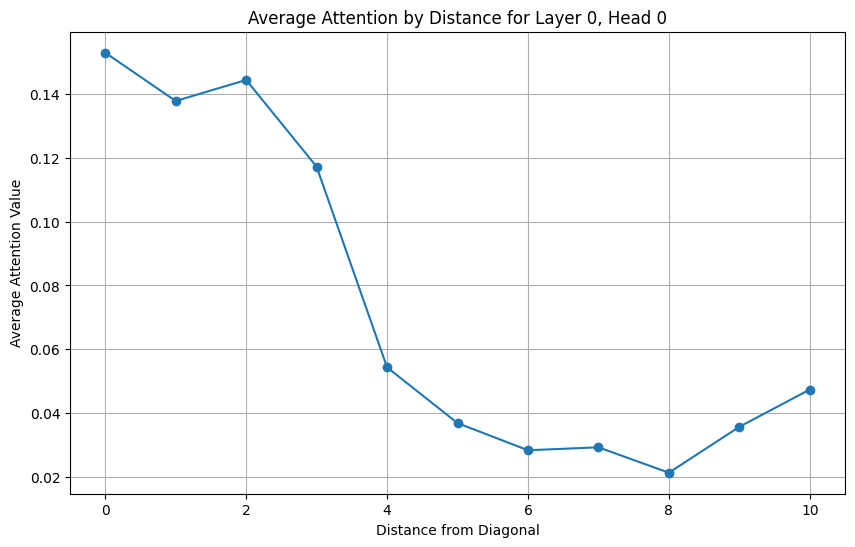

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_attention_by_distance(attn_matrix, title="Average Attention by Distance"):
    """
    Plots the average attention values as a function of the distance from the diagonal.

    Args:
        attn_matrix (np.ndarray): The attention matrix (seq_length x seq_length).
        title (str): Title of the plot.
    """
    seq_length = attn_matrix.shape[0]
    distances = np.abs(np.arange(seq_length)[:, None] - np.arange(seq_length))
    max_distance = np.max(distances)

    # Calculate average attention for each distance
    avg_attention_by_distance = [
        np.mean(attn_matrix[distances == d]) for d in range(max_distance + 1)
    ]

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_distance + 1), avg_attention_by_distance, marker="o", linestyle="-")
    plt.title(title)
    plt.xlabel("Distance from Diagonal")
    plt.ylabel("Average Attention Value")
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `attn_matrix` is the attention matrix from attention_0001[0]
attn_matrix_np = attn_matrix  # Convert to NumPy array if needed
plot_attention_by_distance(attn_matrix_np, title="Average Attention by Distance for Layer 0, Head 0")


In [36]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm


def load_all_attention_matrices(data_dir):
    """
    Loads all attention matrices from a directory.

    Args:
        data_dir (str): Directory containing attention matrices in `.pkl` format.

    Returns:
        list of np.ndarray: List of attention matrices.
    """
    matrices = []
    for filename in tqdm(os.listdir(data_dir), desc="Loading Attention Matrices"):
        if filename.endswith(".pkl"):
            file_path = os.path.join(data_dir, filename)
            with open(file_path, "rb") as f:
                matrix = pickle.load(f)  # Each file contains a list of matrices per layer
                matrices.extend(matrix)  # Combine all layers into one list
    return matrices

def calculate_average_attention_by_distance(matrices):
    """
    Calculates the average attention by distance from the diagonal.

    Args:
        matrices (list of np.ndarray): List of attention matrices.

    Returns:
        np.ndarray: Average attention by distance.
    """
    max_seq_length = max(matrix.shape[-1] for matrix in matrices)
    avg_attention_by_distance = np.zeros(max_seq_length)
    counts = np.zeros(max_seq_length)

    for matrix in matrices:
        if matrix.ndim == 3:
            # Shape: (num_heads, seq_length, seq_length)
            num_heads, seq_length, _ = matrix.shape
            distances = np.abs(np.arange(seq_length)[:, None] - np.arange(seq_length))

            for head in range(num_heads):
                for d in range(seq_length):
                    avg_attention_by_distance[d] += np.sum(matrix[head][distances == d])
                    counts[d] += np.sum(distances == d)
        elif matrix.ndim == 2:
            # Shape: (seq_length, seq_length)
            seq_length, _ = matrix.shape
            distances = np.abs(np.arange(seq_length)[:, None] - np.arange(seq_length))

            for d in range(seq_length):
                avg_attention_by_distance[d] += np.sum(matrix[distances == d])
                counts[d] += np.sum(distances == d)

    # Avoid division by zero
    counts = np.maximum(counts, 1)
    avg_attention_by_distance /= counts
    return avg_attention_by_distance


def plot_aggregated_attention(avg_attention_by_distance, title="Average Attention by Distance"):
    """
    Plots the aggregated average attention values as a function of distance.

    Args:
        avg_attention_by_distance (np.ndarray): Average attention by distance.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(avg_attention_by_distance)), avg_attention_by_distance, marker="o", linestyle="-")
    plt.title(title)
    plt.xlabel("Distance from Diagonal")
    plt.ylabel("Average Attention Value")
    plt.grid(True)
    plt.show()


# Configuration
data_dir = "attention_weights"  # Directory containing attention matrices

# Load all attention matrices
attention_matrices = load_all_attention_matrices(data_dir)

# Calculate the average attention by distance
avg_attention_by_distance = calculate_average_attention_by_distance(attention_matrices)

# Plot the aggregated average attention by distance
plot_aggregated_attention(avg_attention_by_distance, title="Aggregated Average Attention by Distance")


Loading Attention Matrices: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1509.34it/s]


IndexError: too many indices for tensor of dimension 2